In [ ]:
#Import all the libraries

import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
import torch.nn as nn
from torchvision.models import ResNet18_Weights
from tqdm.auto import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path=r"/content/drive/MyDrive/Digital images of defective and good condition tyres"

In [ ]:
data_transforms = transforms.Compose(
    [
        transforms.RandomResizedCrop(size=(256, 256), scale=(0.8, 1.0)),  # Randomly crop and resize to 256x256
        transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
        transforms.RandomRotation(degrees=15),  # Randomly rotate the image by up to 15 degrees
        transforms.RandomGrayscale(p=0.1),  # Randomly convert the image to grayscale with a probability of 0.1
        transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2.0)),  # Apply Gaussian blur with random kernel size and sigma
        transforms.Resize(size=(256, 256)),  # Resize to 256x256
        transforms.ToTensor(),  # Convert to tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize the tensor
    ]
)


In [ ]:
data = torchvision.datasets.ImageFolder(root=path,transform=data_transforms)

In [ ]:
class_names=data.classes
num_classes=len(class_names)

In [ ]:
class_names

['defective', 'good']

In [ ]:
img, label = data[1500]
img.shape

torch.Size([3, 256, 256])

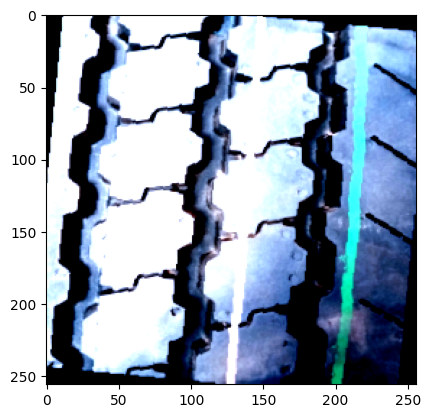

In [ ]:
img = np.transpose(img, (1, 2, 0))

# Now you can display the image
plt.imshow(img)
plt.show()

In [ ]:
len(data)

1856

In [ ]:
#creating the train, validation, test set

torch.manual_seed(42)
val_size = len(data)//10
test_size = len(data)//5
train_size = len(data) - val_size -test_size

In [ ]:
train_ds, val_ds, test_ds = random_split(data, [train_size, val_size, test_size])
len(train_ds), len(val_ds),len(test_ds)

(1300, 185, 371)

In [ ]:

batch_size = 32
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size*2, )
test_loader = DataLoader(test_ds, batch_size*2,)



In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cuda')

In [ ]:
def train_step(model, data, loss_fn, optim):
    model.train()
    train_loss = 0
    for batch, (X, y) in enumerate(data):
        X = X.to(device)
        y = y.unsqueeze(1).float().to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        optim.zero_grad()
        loss.backward()
        optim.step()
    train_loss /= len(data)
    print(f"Train Loss: {train_loss:.4f}")
    return train_loss



In [ ]:

# Validation step function
def val_step(model, data, loss_fn):
    model.eval()
    val_loss = 0
    with torch.inference_mode():
        for batch, (X, y) in enumerate(data):
            X = X.to(device)
            y = y.unsqueeze(1).float().to(device)
            val_pred_logit = model(X)
            loss = loss_fn(val_pred_logit, y)
            val_loss += loss.item()
    val_loss /= len(data)
    print(f"Validation Loss: {val_loss:.4f}")
    return val_loss, None  # No accuracy calculation for simplicity

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5
Train Loss: 0.5689
Validation Loss: 0.4832
Epoch 2/5
Train Loss: 0.4219
Validation Loss: 0.4060
Epoch 3/5
Train Loss: 0.3669
Validation Loss: 0.3633
Epoch 4/5
Train Loss: 0.3414
Validation Loss: 0.3333
Epoch 5/5
Train Loss: 0.3264
Validation Loss: 0.3187


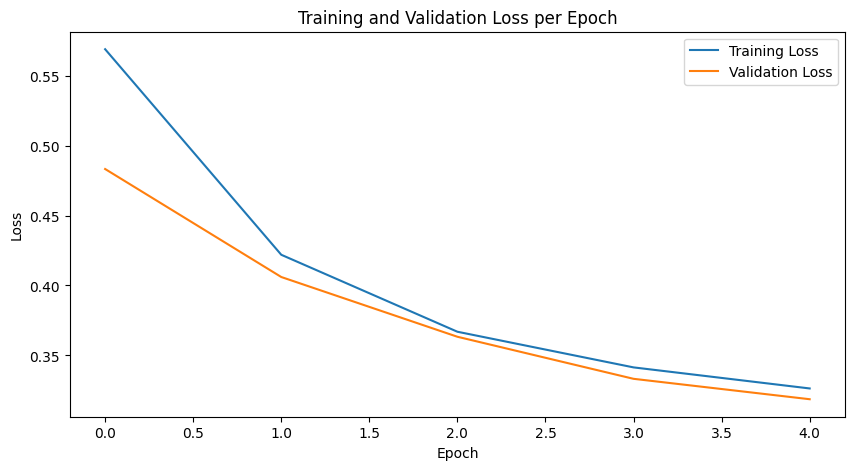

In [ ]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

# Load EfficientNet model
effnet = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)

# Freeze all layers
for params in effnet.parameters():
    params.requires_grad_ = False

# Replace the classifier head
nr_filters = effnet.classifier[1].in_features
effnet.classifier[1] = nn.Linear(nr_filters, 1)
effnet = effnet.to(device)

# Update the optimizer to only optimize the new layer
optimizer = torch.optim.Adam(effnet.classifier[1].parameters())

# Training and validation step functions remain the same
# Use the same train_step, val_step, and training loop with effnet model

# Initialize lists to store loss values
train_losses = []
val_losses = []

# Training loop
torch.manual_seed(42)
loss_fn = nn.BCEWithLogitsLoss()
epochs = 5

for epoch in tqdm(range(epochs)):
    print(f"Epoch {epoch+1}/{epochs}")
    train_loss = train_step(model=effnet, data=train_loader, loss_fn=loss_fn, optim=optimizer)
    val_loss, _ = val_step(model=effnet, data=val_loader, loss_fn=loss_fn)

    # Record the losses
    train_losses.append(train_loss)
    val_losses.append(val_loss)

# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.show()


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 109MB/s] 


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5
Train Loss: 0.5897
Validation Loss: 0.4534
Epoch 2/5
Train Loss: 0.4257
Validation Loss: 0.3692
Epoch 3/5
Train Loss: 0.3661
Validation Loss: 0.3134
Epoch 4/5
Train Loss: 0.3263
Validation Loss: 0.2811
Epoch 5/5
Train Loss: 0.3083
Validation Loss: 0.2631


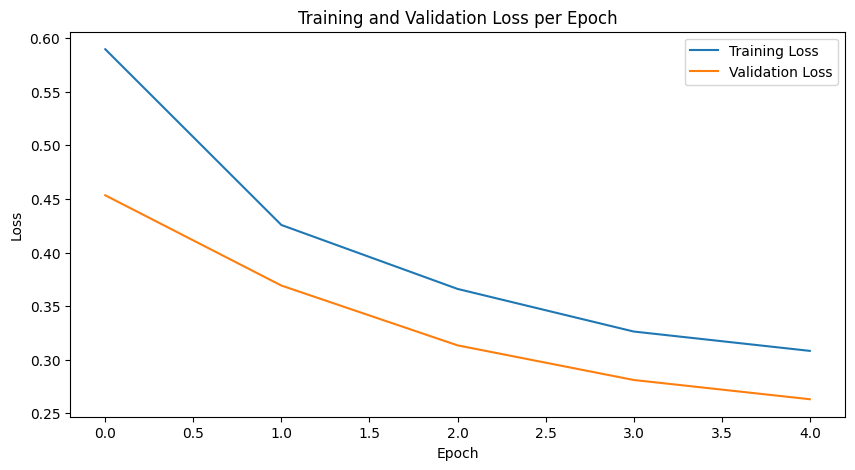

In [ ]:
from torchvision.models import densenet121, DenseNet121_Weights

# Load DenseNet model
densenet = densenet121(weights=DenseNet121_Weights.IMAGENET1K_V1)

# Freeze all layers
for params in densenet.parameters():
    params.requires_grad_ = False

# Replace the classifier head
nr_filters = densenet.classifier.in_features
densenet.classifier = nn.Linear(nr_filters, 1)
densenet = densenet.to(device)

# Update the optimizer to only optimize the new layer
optimizer = torch.optim.Adam(densenet.classifier.parameters())

# Training and validation step functions remain the same
# Use the same train_step, val_step, and training loop with densenet model

# Initialize lists to store loss values
train_losses = []
val_losses = []

# Training loop
torch.manual_seed(42)
loss_fn = nn.BCEWithLogitsLoss()
epochs = 5

for epoch in tqdm(range(epochs)):
    print(f"Epoch {epoch+1}/{epochs}")
    train_loss = train_step(model=densenet, data=train_loader, loss_fn=loss_fn, optim=optimizer)
    val_loss, _ = val_step(model=densenet, data=val_loader, loss_fn=loss_fn)

    # Record the losses
    train_losses.append(train_loss)
    val_losses.append(val_loss)

# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.show()


In [ ]:


device = "cuda" if torch.cuda.is_available() else "cpu"
#res = models.resnet18(pretrained=True)
res = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
#freeze all params
for params in res.parameters():
  params.requires_grad_ = False

#add a new final layer
nr_filters = res.fc.in_features  #number of input features of last layer
res.fc = nn.Linear(nr_filters, 1)

res = res.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 97.7MB/s]


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5
Train Loss: 0.3748
Validation Loss: 0.3447
Epoch 2/5
Train Loss: 0.3497
Validation Loss: 0.3449
Epoch 3/5
Train Loss: 0.3416
Validation Loss: 0.2991
Epoch 4/5
Train Loss: 0.3151
Validation Loss: 0.2948
Epoch 5/5
Train Loss: 0.3093
Validation Loss: 0.2877


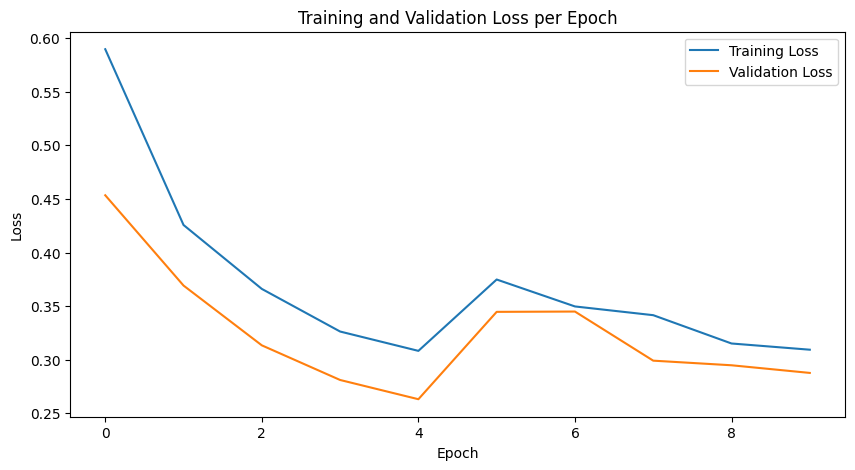

In [ ]:
# Training loop
train_losses = []
val_losses = []

torch.manual_seed(42)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(res.fc.parameters())
epochs = 5

for epoch in tqdm(range(epochs)):
    print(f"Epoch {epoch+1}/{epochs}")
    train_loss = train_step(model=res, data=train_loader, loss_fn=loss_fn, optim=optimizer)
    val_loss, _ = val_step(model=res, data=val_loader, loss_fn=loss_fn)

    # Record the losses
    train_losses.append(train_loss)
    val_losses.append(val_loss)

# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.show()

In [ ]:
test_transfrom=transforms.Compose([
    transforms.Resize(size=(256,256))]
)


In [ ]:
def custom_img_predict(path,models):
  test_img=torchvision.io.read_image(path).type(torch.float32)/255
  plt.imshow(test_img.permute(1,2,0))
  tt_img=test_transfrom(test_img)
  models.eval()
  with torch.inference_mode():
    test=models(tt_img.unsqueeze(0).to(device))

  test_prob=torch.softmax(test, dim=1)
  test_label=torch.argmax(test_prob, dim=1).cpu()
  name=class_names[test_label]
  print(f"the trye predicted is {name}")
  #return  img

the trye predicted is defective


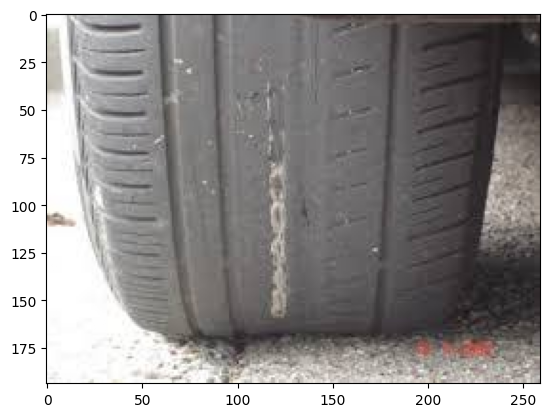

In [ ]:
custom_img_predict('/content/images.jpeg',models=densenet)

the trye predicted is defective


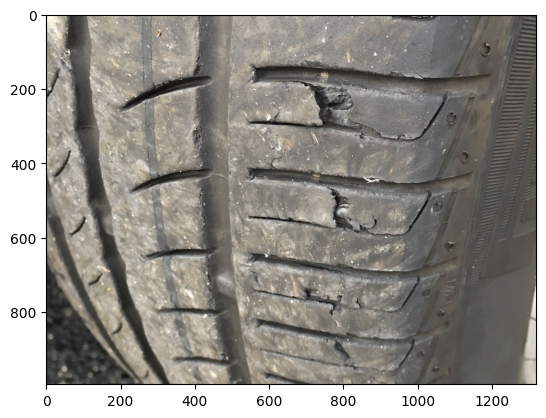

In [ ]:
custom_img_predict('/content/defective-tires-cause-accidents-min.jpg',models=effnet)

In [ ]:
torch.save(res.state_dict(), 'resnet18_finetuned.pth')

In [ ]:
torch.save(densenet.state_dict(), 'densenet_finetuned.pth')

In [ ]:
torch.save(effnet.state_dict(), 'effnet_finetuned.pth')